# Gaussian Quadrature

Here we consider the problem of efficiently estimating expected value integrals for a nonlinear function $f(\pmb{x}) : \mathbb{R}^n \to \mathbb{R}^m$
\begin{equation}
E[f(\pmb{x})] = \int_{\mathbb{R}^n} f(\pmb{x}) N(\pmb{x} | \pmb{0}, I) d \pmb{x}.
\end{equation}
Here the notation $N(\pmb{x} | \pmb{0}, I)$ is shorthand for the Gaussian probability density function with mean $\pmb{0}$ and identity covariance matrix, evaluated at the point $\pmb{x}$. In Bayesian filtering applications, the Gaussian weighting function is also referred to as the prior distribution. General Gaussian weight functions $N(\pmb{x} | \pmb{x_0}, P_x)$ are handled by performing a change of variables
\begin{equation}
\int_{\mathbb{R}^n} f(\pmb{x}) N(\pmb{x} | \pmb{x_0}, P_x) d \pmb{x} = \int f(\pmb{x_0} + \sqrt{P_x} \chi) N(\pmb{\chi} | \pmb{0}, I) d \pmb{x}
\end{equation}
where $\sqrt{P_x}$ is a matrix square root (typically obtained by Cholesky factorization) of the covariance matrix $P_x$. We will look at quadrature rules of the form 
\begin{equation}
 E[f(\pmb{x})] \approx Q[f(\pmb{x})] = \sum_i w_i f(\pmb{\chi_i})
\end{equation}
with quadrature points $\pmb{\chi_i}$, also called sigma points, and associated weights $w_i$. 

## Classifying Accuracy

The order of accuracy of a Gaussian quadrature rule is usually classified in terms of the degrees of polynomial functions that it can integrate exactly. For multivariate functions we need a few definitions. 
\begin{definition}[Monomial  Function]
A monomial of degree $d$ refers to a function 
\begin{equation}
x_1^{N_1} x_2^{N_2} \cdots x_n^{N_n}
\end{equation}
where the $N_i$ are non-negative integers that sum to $d$.
\end{definition}
A multivariate polynomial of degree $d$ is simply a weighted sum of monomial functions with highest degree $d$ A Gaussian quadrature is said to be $d$-th order if it can exactly integrate expectation integrals for polynomial functions $f(\pmb{x})$ up to and including degree $d$. 

## Gauss-Hermite Quadrature

A standard approach to generate quadrature in many dimensions involves taking tensor products of 1D quadrature rules. In 1D, the third order Gauss-Hermite rule is given by 
\begin{equation}
\int_{\mathbb{R}} f(x) N(x | 0, 1) \; dx \approx \frac{2}{3} f \left ( 0 \right ) + \frac{1}{6} f \left ( -\sqrt{3} \right ) + \frac{1}{6} f \left ( \sqrt{3} \right )
\end{equation}

In $n$ dimensions, sigma points for the third order Gauss-Hermite rule are generated by taking tensor products of the three 1D sigma points. This yields a grid of $3^n$ points. Below we show an example in 3 dimensions. The size of each point corresponds to its weight. 


<IPython.core.display.Javascript object>


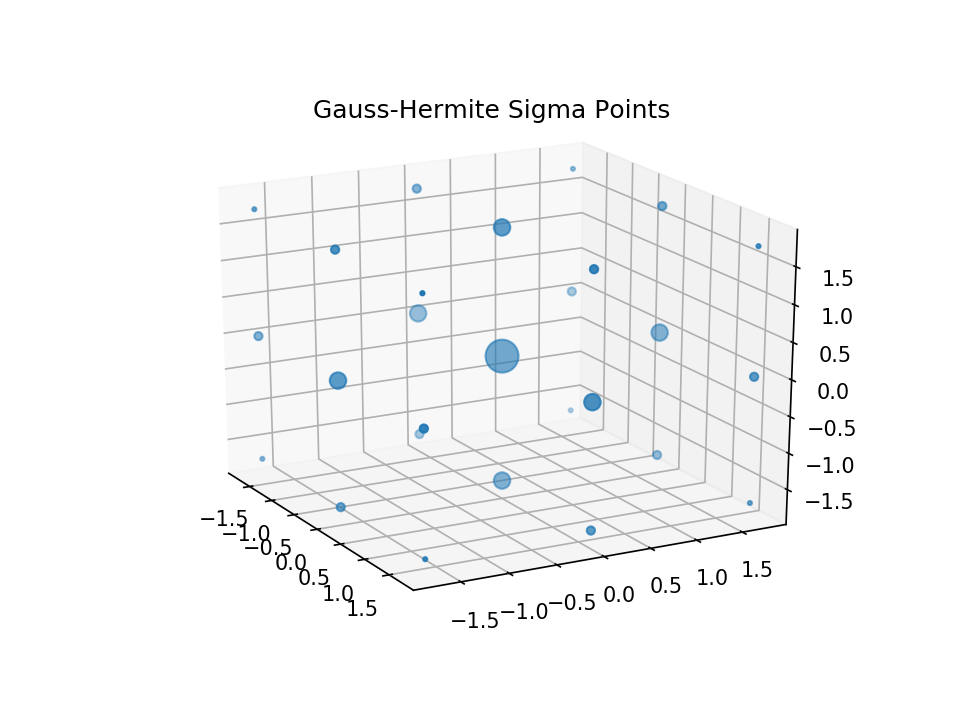

In [16]:
from filterpy.kalman.tut.tut_sigmas import TutSigmaPoints
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Prior mean
x0 = np.zeros(3)
# Prior covariance
Px = np.eye(3)
# Gauss-Hermite sigma points
points = TutSigmaPoints()
X, wm, wc = points.get_set(x0, Px, set_name = 'hermite')

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Gauss-Hermite Sigma Points')
ax.scatter(X[0,:], X[1,:], X[2,:], s = 250.*wm / wm.max())
plt.show()

There is a clear drawback of the Gauss-Hermite quadrature rule. The number of sigma points grows exponentially with the state dimension! Hence, while the Gauss-Hermite rule is a useful for low dimensional problems, it is intractable for larger problems. 

## The Unscented Transform as a Quadrature Rule
The unscented transform, introduced in \cite{Julier1997}, is a highly efficient quadrature rule of degree $d=3$. There are several formulations of the unscented transform, but we'll look at a common version that uses set of $2n + 1$ sigma points. Here, the notation $\pmb{e_i}$ refers to the $i$-th column of the $n \times n$ identity matrix. Points are given by
\begin{equation}
\pmb{\chi_i} =
\begin{cases} 
      \pmb{x_0} & i = 0 \\
      \pmb{x_0} - \sqrt{n + \kappa} \pmb{e_i} & i = 1, \cdots, n\\
      \pmb{x_0} + \sqrt{n + \kappa} \pmb{e_i} & i = n+1, \cdots, 2n
\end{cases}
\end{equation}
with weights
\begin{equation}
w_i^m = w_i^c =
\begin{cases} 
      \frac{\kappa}{n + \kappa} & i = 0 \\
      \frac{1}{2(n+\kappa)} & i = 1, \cdots, 2n.
\end{cases}
\end{equation}
Let's look at a particular example. Suppose that 
\begin{equation}
f([x_0, x_1, x_2]) = [x_1 x_2 + 1, \: x_2^2, \: 5 x_0 x_1 x_2 + 2 x_1]
\end{equation}
Below we compute the expected value $ E[f(\pmb{x})]$ using both random sampling and the unscented transform using the Julier sigma points.

Expected value from random sampling: [ 0.99080139  1.00731992 -0.04053512]
Expected value from Gauss-Hermite: [1.00000000e+00 1.00000000e+00 5.55111512e-17]
Expected value from UT: [1. 1. 0.]


<IPython.core.display.Javascript object>


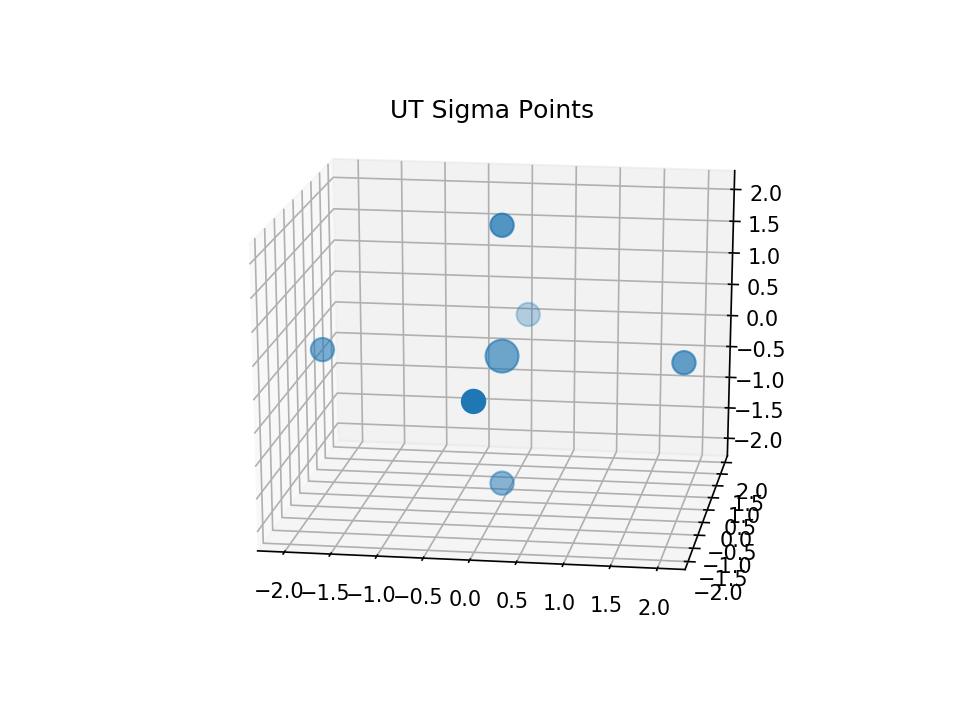

In [17]:
from numpy.random import multivariate_normal

# Nonlinear function
def f(X):
    return np.array([X[1,:]*X[2,:] + 1., X[2,:]**2, 5.*X[0,:]*X[1,:]*X[2,:] + 2.*X[1,:]])

# Estimate expected value via random sampling
samples = f(multivariate_normal(np.zeros(3), np.eye(3), 5900).T)
y_mean1 = samples.mean(axis = 1)

# Estimate using Gauss-Hermite
X, wm, wc = points.get_set(x0, Px, set_name = 'hermite')
y_mean2 = f(X) @ wm

# Estimate using UT
X, wm, wc = points.get_set(x0, Px, set_name = 'julier', kappa = 1.)
y_mean3 = f(X) @ wm

print("Expected value from random sampling: {}".format(y_mean1))
print("Expected value from Gauss-Hermite: {}".format(y_mean2))
print("Expected value from UT: {}".format(y_mean3))


# Plot UT sigmas 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('UT Sigma Points')
ax.scatter(X[0,:], X[1,:], X[2,:], s = 250.*wm / wm.max())
plt.show()

In this case, both the Gauss-Hermite method and the UT exactly (to machine precision) compute the expected value integral since the $f(\pmb{x})$ has terms involving polynomials of at most degree 3. However, the UT only needs 7 sigma points versus 27 for Gauss-Hermite. Nice!

## Higher Order Terms and Integration Error

What about higher order polynomials or non-polynomial functions? A drawback of using a fixed number of sigma points versus taking random samples via MCMC methods is that the order of accuracy is necessarily fixed. For some nonlinear functions, the unscented approximation will be highly accurate (or even perfect), but for others, higher order polynomial terms in the Taylor series expansion for $f$ will result in integration errors. In contrast, MCMC methods can compute expectation integrals to arbitrary precision given enough samples. 

Generally, the unscented transform provides more accurate estimates relative to the number of required sigma points. Different quadrature rules and different selections of the scaling parameters for those rules will affect their performance for a given problem. TUT includes algorithms for generating sigma points for several Gaussian quadrature rules with different numbers of sigma points and degrees of accuracy. 